We are going to use image embeddings from ResNeXt for both EDA and classification, so let's add some code that will get those for us.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 104MB/s]


Next let's get our image embeddings and thumbnails.

In [2]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)
TEST = '/kaggle/input/fruits-classification-dataset/fruits/test'
TRAIN = '/kaggle/input/fruits-classification-dataset/fruits/train'
VALIDATION = '/kaggle/input/fruits-classification-dataset/fruits/validation'


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.endswith('.png') and index < 500]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
validation_dict = {basename(folder) : folder + '/*.*' for folder in iglob(VALIDATION + '/*')}
validation_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in validation_dict.items()]))
train_df = pd.concat(axis='index', objs=[train_df, validation_df])
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*')}
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 145 rows of orange  in 0:00:26.407758
encoded 162 rows of apple  in 0:00:28.467454
encoded 153 rows of banana  in 0:00:27.424769
encoded 21 rows of orange  in 0:00:03.804673
encoded 23 rows of apple  in 0:00:04.261406
encoded 22 rows of banana  in 0:00:03.979272
encoded 40 rows of orange  in 0:00:07.657991
encoded 47 rows of apple  in 0:00:09.380413
encoded 43 rows of banana  in 0:00:08.165779
done in 0:01:59.647733


Now let's use TSNE to get x/y coordinates. We need to do this twice, once for the training data and again for the test data, because we can't reuse the sklearn TSNE reducer, and because we will want to scatter plot both datasets.

In [3]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 526 samples in 0.004s...
[t-SNE] Computed neighbors for 526 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 526 / 526
[t-SNE] Mean sigma: 1.482176
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.457611
[t-SNE] KL divergence after 1000 iterations: 0.564728
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 130 samples in 0.001s...
[t-SNE] Computed neighbors for 130 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 130 / 130
[t-SNE] Mean sigma: 2.574372
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.282997
[t-SNE] KL divergence after 1000 iterations: 0.163143


Now we're ready to plot.

In [4]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: fruit', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=7, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? We see an almost embarassingly good result. There are literally zero difficult cases. We even get separate clusters for red and green apples, and tiny microclusters for partly peeled bananas and unripe oranges. We should expect even a simple model to be highly accurate for this dataset. Let's build one and find out.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(train_df['value'].apply(pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(pd.Series)))))
print(classification_report(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(pd.Series))))

model fit in 58 iterations
accuracy: 1.0000
f1: 1.0000
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        47
      banana       1.00      1.00      1.00        43
      orange       1.00      1.00      1.00        40

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



Yep. Let's see if there are any cases where the model is less than certain.

<Axes: xlabel='x', ylabel='y'>

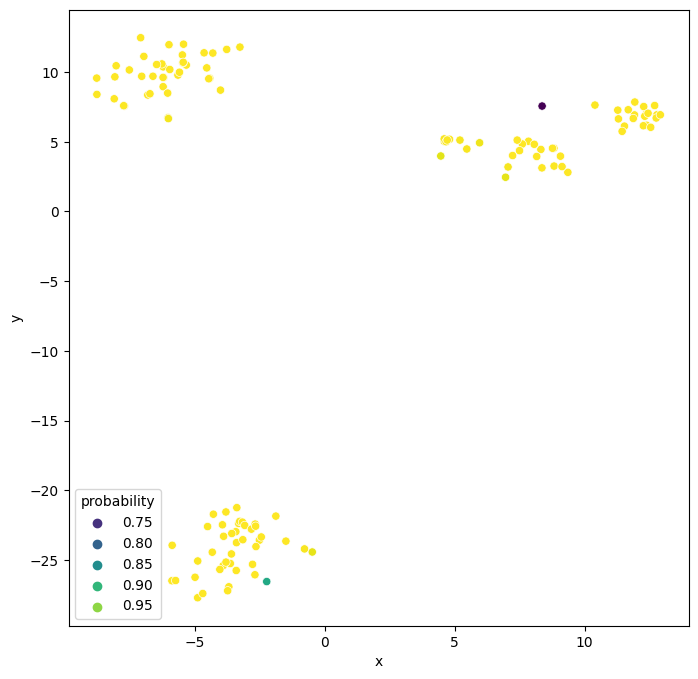

In [6]:
import matplotlib.pyplot as plt
from seaborn import scatterplot

fig, ax = plt.subplots(figsize=(8, 8))
plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)
scatterplot(ax=ax, data=plot_df, x='x', y='y', hue='probability', palette='viridis')

Our model probablities are almost always high; we have literally two cases that are less than certain. Not bad for almost no work.